<a href="https://colab.research.google.com/github/olcaykursun/ML/blob/main/neuralnets/document_classification_and_word_embeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
from gensim.models import KeyedVectors
import gensim.downloader as api

# Load or download Word2Vec model
if 'wv' not in globals():
    model_path = '/Users/okursun/Downloads/uk/word2vec-google-news-300'

    if not os.path.exists(model_path):
        wv = api.load(model_path)
        wv.save(model_path)
    else:
        wv = KeyedVectors.load(model_path)

d = 300  # number of dimensions for Word2Vec

In [ ]:
wv['king'].shape # each word is converted to 300 dimensional vector

(300,)

In [ ]:
# what can this new word be? king-man+woman
new_word = wv['king'] - wv['man'] + wv['woman']

import numpy as np

# lets calculate the Euclidean distance between the new_word and "queen"
# (just like Pythagorean theorem states, square the differences, add them up, and take square root)
np.sqrt(sum((new_word - wv['queen'])**2))

2.298657801924729

In [ ]:
# "lion" is not as close to "new_word"
np.sqrt(sum((new_word - wv['lion'])**2))

3.9450453627154123

In [ ]:
# try something like cats-cat+dog, it should be close to "dogs"
new_word = wv['cats'] - wv['cat'] + wv['dog']

print(np.sqrt(sum((new_word - wv['dogs'])**2)))
print(np.sqrt(sum((new_word - wv['horses'])**2)))

1.3791011529383266
3.2215298249921105


In [ ]:
# Hard to make strong assumptions about the vectors tho. Why are these two very far?
# Could be because we never have "HORSE" appear with words that appear with "horse"
# maybe HORSE was a sports club name who knows.

np.sqrt(sum((wv['horse'] - wv['HORSE'])**2))

4.527754358937501

In [ ]:
from sklearn.datasets import fetch_20newsgroups

# Load the 20 Newsgroups dataset
newsgroups = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'))
n_classes = 20  # number of classes

print(newsgroups.data[0])
print(len(newsgroups.data[0]))

print('class label', newsgroups.target[0]) #class label
print('title of the class', newsgroups.target_names[newsgroups.target[0]])



I am sure some bashers of Pens fans are pretty confused about the lack
of any kind of posts about the recent Pens massacre of the Devils. Actually,
I am  bit puzzled too and a bit relieved. However, I am going to put an end
to non-PIttsburghers' relief with a bit of praise for the Pens. Man, they
are killing those Devils worse than I thought. Jagr just showed you why
he is much better than his regular season stats. He is also a lot
fo fun to watch in the playoffs. Bowman should let JAgr have a lot of
fun in the next couple of games since the Pens are going to beat the pulp out of Jersey anyway. I was very disappointed not to see the Islanders lose the final
regular season game.          PENS RULE!!!


712
class label 10
title of the class rec.sport.hockey


In [ ]:
len(newsgroups.data)

18846

In [ ]:
newsgroups.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

In [ ]:
# We will learn our own word embeddings too.
# We may want to get rid of stopwords
# We also want to delete words that are not in Word2Vec so that we can compare their performances
# So, let's clean up the dataset

import nltk
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.text import Tokenizer


# Download and load NLTK stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Initialize and fit the tokenizer
tokenizer = Tokenizer(num_words=10000)  # Adjust the num_words as per your dataset/vocabulary size
tokenizer.fit_on_texts(newsgroups.data)

# Function to preprocess text and filter out stopwords and non-Word2Vec words
def clean_and_filter(text):
    sequence = tokenizer.texts_to_sequences([text])[0]
    return [tokenizer.index_word[token] for token in sequence
            if tokenizer.index_word[token] not in stop_words
            and tokenizer.index_word[token] in wv.key_to_index
            and not tokenizer.index_word[token].isdigit()
            and len(tokenizer.index_word[token])>=3]

# Preprocess and filter the dataset
preprocessed_data = [clean_and_filter(doc) for doc in newsgroups.data]

tokenizer = Tokenizer()  #this will label each word with an index (integer-label)
tokenizer.fit_on_texts(preprocessed_data)

# we can find out how many words exist in the text dataset (after cleaning it up)
vocab_size = len(tokenizer.word_index)
print(f"Number of unique clean-tokens (we will need this number for training our model): {vocab_size}")


# Convert filtered words to Word2Vec indices: now lets create a sequence of integers!
# Each document is not a sequence of integers (not characters anymore)
sequences = [[tokenizer.word_index[word] for word in doc] for doc in preprocessed_data]

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/okursun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Number of unique clean-tokens (we will need this number for training our model): 7811


In [ ]:
# That first post is now turned into a sequence of integers
print(sequences[0])

[75, 2451, 1255, 283, 2400, 1037, 220, 1163, 808, 2451, 1968, 2452, 126, 72, 72, 84, 48, 117, 135, 159, 3241, 72, 5289, 2451, 170, 1248, 2452, 1075, 189, 1408, 22, 68, 980, 480, 1604, 7, 121, 1483, 955, 1990, 6481, 156, 121, 1483, 171, 386, 261, 37, 2451, 48, 1551, 2690, 355, 7192, 19, 2384, 1449, 772, 980, 480, 114, 2451, 949]


In [ ]:
# if we want to go back to words from the index integers, we can use index_word
print([tokenizer.index_word[i] for i in sequences[0]])

['sure', 'pens', 'fans', 'pretty', 'confused', 'lack', 'kind', 'posts', 'recent', 'pens', 'massacre', 'devils', 'actually', 'bit', 'bit', 'however', 'going', 'put', 'end', 'non', 'relief', 'bit', 'praise', 'pens', 'man', 'killing', 'devils', 'worse', 'thought', 'showed', 'much', 'better', 'regular', 'season', 'stats', 'also', 'lot', 'fun', 'watch', 'playoffs', 'bowman', 'let', 'lot', 'fun', 'next', 'couple', 'games', 'since', 'pens', 'going', 'beat', 'jersey', 'anyway', 'disappointed', 'see', 'islanders', 'lose', 'final', 'regular', 'season', 'game', 'pens', 'rule']


In [ ]:
# we have the mapping from the word to the index of course
print(tokenizer.word_index['sure'])

75


In [ ]:
print([tokenizer.index_word[i] for i in sequences[1]])
print('\nlength of the sequence', len(sequences[1]))
print(newsgroups.target_names[newsgroups.target[1]])

['brother', 'market', 'high', 'performance', 'video', 'card', 'supports', 'local', 'bus', '2mb', 'ram', 'anyone', 'suggestions', 'ideas', 'diamond', 'stealth', 'pro', 'local', 'bus', 'orchid', 'ati', 'graphics', 'ultra', 'pro', 'high', 'performance', 'vlb', 'card', 'please', 'post', 'email', 'thank', 'matt']

length of the sequence 33
comp.sys.ibm.pc.hardware


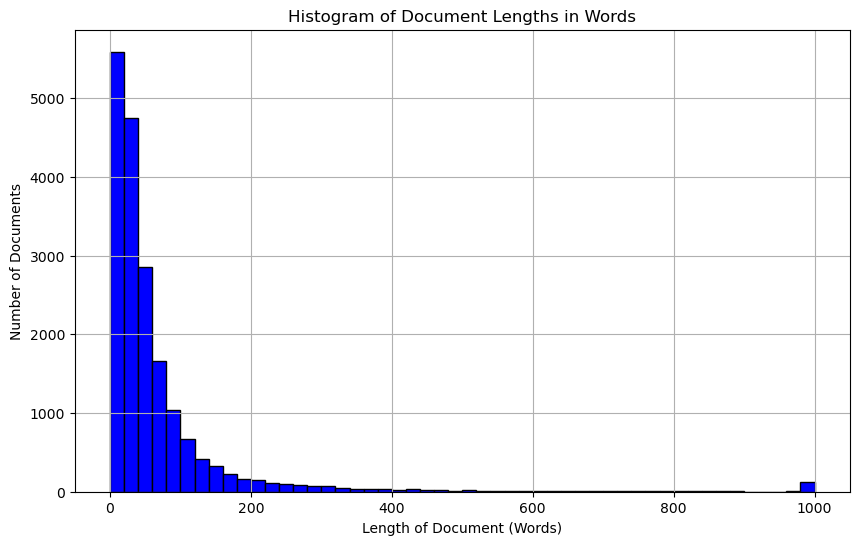

number of documents after discarding very short ones: 11881


In [ ]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences


# Calculate the length of each document in words
doc_lengths = [len(doc) for doc in sequences]
doc_lengths = np.array(doc_lengths)
doc_lengths[doc_lengths>1000]=1000

# Create a histogram of document lengths
plt.figure(figsize=(10, 6))
plt.hist(doc_lengths, bins=50, color='blue', edgecolor='black')
plt.title('Histogram of Document Lengths in Words')
plt.xlabel('Length of Document (Words)')
plt.ylabel('Number of Documents')
plt.grid(True)
plt.show()

# let's discard the very short documents
min_length = 25
long_indices = doc_lengths >= min_length
print('number of documents after discarding very short ones:', sum(long_indices))

newsgroupsdata = [doc for doc, keep in zip(newsgroups.data, long_indices) if keep]
newsgroupstarget = [doc for doc, keep in zip(newsgroups.target, long_indices) if keep]
sequences = [doc for doc, keep in zip(sequences, long_indices) if keep]
preprocessed_data = [doc for doc, keep in zip(preprocessed_data, long_indices) if keep]


#Let us trim the very long docs (say longer than 250 clean-tokens) because we will need padding to make them all equal length
max_length = 250
trimmed_sequences = [seq[:max_length] for seq in sequences]

class_to_indices = {cls: [] for cls in range(n_classes)}
for idx, label in enumerate(newsgroupstarget):
    class_to_indices[label].append(idx)

X_train, X_test, y_train, y_test, untrimmed_X_train, untrimmed_X_test = train_test_split(trimmed_sequences, newsgroupstarget, sequences, train_size = 0.5)
y_train_categorical = to_categorical(y_train, num_classes=20)
y_test_categorical = to_categorical(y_test, num_classes=20)

# X_train is a list of lists where each sublist is a sequence of integer tokens
X_train_padded = pad_sequences(X_train, padding='post')
X_test_padded = pad_sequences(X_test, padding='post')

index_to_word = {index: word for word, index in tokenizer.word_index.items()}

In [ ]:
# notice the 0s at the end (short docs are padded with zeros, representing no token)
# 0 is also known as padding token
print(X_train_padded)

# we could also pad with 0s at the beginning
#X_train_padded = pad_sequences(X_train, padding='pre')

# padding at the beginning (pre-padding) is often preferred, because the models can be sensitive
# to the most recently seen input at the later stages of processing,
# which is often crucial for tasks like sentiment analysis or language modeling.

[[  85  266   32 ...    0    0    0]
 [   6 5787 1301 ...    0    0    0]
 [ 489 3752  446 ...    0    0    0]
 ...
 [1271   16    1 ...    0    0    0]
 [ 163  368 2083 ...    0    0    0]
 [   2    3 1549 ...    0    0    0]]


In [ ]:
from keras.models import Sequential
from keras.layers import Embedding, GlobalAveragePooling1D, GlobalMaxPooling1D, Dense
from keras.optimizers.legacy import Adam
from tensorflow.keras.models import Model

batch_size = 128
num_features = 50  # instead of 300 dimensional Word2Vec, learn 50 dimensional word embeddings of our own
lr = 0.01
activation = 'relu'
n_epochs = 10

def create_new_model(n_out):
    new_model = Sequential([
        Embedding(vocab_size, num_features, input_length=None),
        GlobalAveragePooling1D(),
        Dense(n_classes, activation='softmax')
    ])
    return new_model

# Create the randomized model
model = create_new_model(20)

model.compile(optimizer=Adam(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy'])

# Fit the model
model.fit(X_train_padded, y_train_categorical, epochs=n_epochs, batch_size = batch_size)

Epoch 1/10
47/47 [==============================] - 8s 162ms/step - loss: 2.8864 - accuracy: 0.1673
Epoch 2/10
47/47 [==============================] - 8s 161ms/step - loss: 2.3599 - accuracy: 0.4515
Epoch 3/10
47/47 [==============================] - 8s 162ms/step - loss: 1.7153 - accuracy: 0.6727
Epoch 4/10
47/47 [==============================] - 8s 164ms/step - loss: 1.2377 - accuracy: 0.8005
Epoch 5/10
47/47 [==============================] - 8s 165ms/step - loss: 0.9194 - accuracy: 0.8579
Epoch 6/10
47/47 [==============================] - 8s 160ms/step - loss: 0.7018 - accuracy: 0.8938
Epoch 7/10
47/47 [==============================] - 7s 158ms/step - loss: 0.5459 - accuracy: 0.9200
Epoch 8/10
47/47 [==============================] - 8s 160ms/step - loss: 0.4329 - accuracy: 0.9414
Epoch 9/10
47/47 [==============================] - 7s 160ms/step - loss: 0.3426 - accuracy: 0.9542
Epoch 10/10
47/47 [==============================] - 7s 155ms/step - loss: 0.2717 - accuracy: 0.9715

In [ ]:
# We utilized the training set to learn embeddings using the 20 available classes.
# This approach might seem like "cheating" since, typically, embeddings are learned through a general task

# For example Word2Vec learned its embeddings from another dataset, but it is still useful for 20 newsgroups.

#Nevertheless, we could simply use the trained model to see how successful it is on the test set.
loss, accuracy = model.evaluate(X_test_padded, y_test_categorical)
print(loss, accuracy)

186/186 [==============================] - 2s 9ms/step - loss: 0.8460 - accuracy: 0.7765
0.8460397720336914 0.7764686346054077


In [ ]:
# Now we can also save our embedding as a dictionary, just like wv, that of Word2Vec.
num_layers_top = 2
feature_extractor_model = Model(inputs=model.input, outputs=model.layers[-num_layers_top-1].output)

unique_tokens = set()  # Set of unique tokens
for sequence in sequences:
    unique_tokens.update(sequence)  # Add all tokens from each sequence

unique_tokens_array = np.array(list(unique_tokens)).reshape(-1, 1)
print("Shape of unique_tokens_array:", unique_tokens_array.shape)

trained_embeddings = feature_extractor_model.predict(unique_tokens_array, verbose=0)
embeddings_dict = {token: embedding.flatten() for token, embedding in zip(unique_tokens, trained_embeddings)}

Shape of unique_tokens_array: (7811, 1)


In [ ]:
tokenizer.index_word[7810]

'connects'

In [ ]:
# here is our word embedding for it
print(embeddings_dict[7810])

[-0.44752574  1.3956691   0.8825214   1.2929667   0.99094343  0.04747923
  0.10502639  0.6074659   0.9819442   0.01558299 -0.10510104 -1.297634
 -0.25372455 -0.84939486 -0.21765006 -0.3747155   0.46300262 -0.6576389
  0.87825817 -1.0076163   0.81278515  0.39916593 -1.502316    0.888802
 -1.2092725   0.5086421  -0.60077024  1.1997204   0.03143848 -0.07029895
  0.22367598  1.2802098   1.190508    1.2984169   1.4879626  -0.27992663
 -1.4842571   0.7291012   1.0820291   1.4088069  -1.5072681  -0.8379125
 -1.4017293  -0.2685657  -0.3070296   0.752324   -0.31379655 -0.6908782
  1.0215816  -0.9434857 ]


In [ ]:
print(tokenizer.word_index['better'])
print(tokenizer.word_index['good'])
print(tokenizer.word_index['bigger'])
print(tokenizer.word_index['big'])

68
16
2459
232


In [ ]:
# These equations (semantic arithmetic or word analogies) will not work as good for ours because
# we used supervised learning on a small dataset (targeting a very specific set of 20 classes)
new_word = embeddings_dict[68] - embeddings_dict[16] + embeddings_dict[232]
print(np.sqrt(sum((new_word - embeddings_dict[2459])**2)))

6.563065034005152


In [ ]:
new_word = embeddings_dict[68] - embeddings_dict[16] + embeddings_dict[232]
print(np.sqrt(sum((new_word - embeddings_dict[5000])**2)))

10.326661359621742


In [ ]:
tokenizer.index_word[5000]

'banned'

In [ ]:
tokenizer.word_index['computer']

144

In [ ]:
tokenizer.word_index['disk']

201

In [ ]:
print(np.sqrt(sum((embeddings_dict[144] - embeddings_dict[201])**2)))

8.846334854296174


In [ ]:
def document_vector(doc, embedding_dict):
    # Retrieve the embedding for each integer key in the document
    embeddings = [embedding_dict[key] for key in doc]
    # Calculate the average of these embeddings
    return np.mean(np.array(embeddings), axis=0)

X_train_vectors = np.array([document_vector(doc, embeddings_dict) for doc in X_train])
X_test_vectors = np.array([document_vector(doc, embeddings_dict) for doc in X_test])


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

# Initialize and train the logistic regression model
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train_vectors, y_train)

# Predict and evaluate the model
y_pred = logreg.predict(X_test_vectors)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 0.7826965157380912
              precision    recall  f1-score   support

           0       0.65      0.60      0.63       269
           1       0.74      0.77      0.75       264
           2       0.71      0.66      0.68       274
           3       0.66      0.67      0.66       325
           4       0.77      0.69      0.73       293
           5       0.82      0.86      0.84       292
           6       0.83      0.80      0.82       288
           7       0.80      0.82      0.81       251
           8       0.86      0.84      0.85       257
           9       0.93      0.90      0.91       286
          10       0.95      0.94      0.94       332
          11       0.90      0.87      0.88       355
          12       0.71      0.76      0.73       317
          13       0.85      0.89      0.87       308
          14       0.87      0.87      0.87       320
          15       0.67      0.87      0.75       364
          16       0.75      0.74      0.74       33